# Using ICA to reduce artefacts

This section will show how to use an independent component analysis (ICA) approach to suppress ocular and cardiac artefacts. This will be done by first performing an ICA decomposition of the data after which the components reflecting the artefacts are identified manually. As a last step the artefact components are 'projected out'.

## Preparation
#### Import the necessary modules
Below are the required Python modules to be imported

In [1]:
import mne
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
from mne_bids import (
    BIDSPath,
    read_raw_bids
)
from mne.preprocessing import ICA

#### File overview

The chapter relies on the file (embedded in the BIDS structure):

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif

and generates the output files:

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif


#### The filtered data is saved inside the derivative folder of the BIDS Directory. To import the data in this workspace the following steps will be followed.

#### Specify your BIDS parameters along with the BIDS folder path

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
hfc_suffix = 'raw_hfc'
ann_suffix = 'ann'
ica_suffix='ica'

data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/preprocessing")

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=ann_suffix, 
            root=deriv_root, extension='.fif', check=False)

deriv_fname = bids_path.basename.replace(ann_suffix, ica_suffix) # fif output filename
deriv_fname_fif = op.join(bids_path.directory, deriv_fname)


print(bids_path)
print(deriv_fname_fif)


C:/Users/rakshita/Documents/Cerca_raw_files/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ica.fif



## Resampling and filtering of the raw data

To make ICA work more efficiently and allow all parts of the data to stay in memory, the data will be downsampled. The version of the dataset that has already been cleaned using HFC and has annotations will be used. This data will be resampled to 250 Hz, and then a bandpass filter between 1 and 40 Hz will be applied. The high-pass filter at 1 Hz is especially important because it removes slow drifts in the signal, which can otherwise make ICA less effective.


In [3]:
# Read the raw data from the BIDS path
raw = read_raw_bids(bids_path=bids_path, extra_params={'preload': True}, verbose=True)

# Process the raw data
raw_resmpl = raw.copy().pick('mag')  
raw_resmpl.filter(3, 30)  
raw_resmpl.resample(250)  


Opening raw data file C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ann.fif...


C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\2274475918.py:2: RuntimeWarning: This filename (C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload': True}, verbose=True)


    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 176) active
        HFC: l=1 m=0 (1 x 176) active
        HFC: l=1 m=1 (1 x 176) active
        HFC: l=2 m=-2 (1 x 176) active
        HFC: l=2 m=-1 (1 x 176) active
        HFC: l=2 m=0 (1 x 176) active
        HFC: l=2 m=1 (1 x 176) active
        HFC: l=2 m=2 (1 x 176) active
    Range : 0 ... 1539807 =      0.000 ...  2053.076 secs
Ready.
Reading 0 ... 1539807  =      0.000 ...  2053.076 secs...


C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\2274475918.py:2: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\**\meg\sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload': True}, verbose=True)
C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\2274475918.py:2: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\**\meg\sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload': True}, verbose=True)
C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\2274475918.py:2: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\raksh

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1239 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    9.0s


<Raw | sub-01_ses-01_task-SpAtt_run-01_ann.fif, 176 x 513269 (2053.1 s), ~694.8 MiB, data loaded>


## Applying the ICA algorithm

Now the ICA algorithm will be applied. The fastica approach is chosen as it is well established and widely used. However, other ICA methods are available in MNE-Python. To expedite the computation, it is decided to restrict the ICA to the initial 30 components.


In [4]:
raw_resmpl_all = raw_resmpl
ica = ICA(method='fastica',
    random_state=96,
    n_components=30,
    verbose=False)

ica.fit(raw_resmpl_all,
    verbose=False,
       picks='meg')

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,55 iterations on raw data (508000 samples)
ICA components,30
Available PCA components,176
Channel types,mag
ICA components marked for exclusion,—



## Identifying the ICA components reflecting the artefacts

To plot the examples for the time-traces of the ICA components use:


In [5]:
%matplotlib inline
ica.plot_sources(raw_resmpl_all, title='ICA');

    Applying projection operator with 8 vectors (pre-whitener application)
Creating RawArray with float64 data, n_channels=30, n_times=513269
    Range : 0 ... 513268 =      0.000 ...  2053.072 secs
Ready.
Using qt as 2D backend.


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Use the left/right arrow-keys to scroll through the data and the up/down arrow-keys to scroll through the components. Right-click on the IC names to see the corrisponding topographies and other details.

When inspecting the traces, it is clear that ICA006 reflects eye-blinks as measured most strongly and ICA011 reflects the ECG. This order of ICA components is specific to this data set and the seed (random_state) used for the ICA decomposition. For other data sets or using a different seed the components will come in a different order. Therefore the components associated with artefacts have to be identified manually.

- **Question 1:** Identify the saccades in ICA006

## Attenuating the artefacts by applying the projections

Now the ICA components associated with ocular and cardiac artefacts are detected, hence it must be 'projected out'. This will be done by applying the ICA projections generated by ica.exclude to the original raw data which will be loaded again. After the ICA projections have been applied *(ica.apply)* the data will be saved.

In [6]:
# Set the 4 components to exclude
ica.exclude = [6,11]


raw_ica = read_raw_bids(bids_path=bids_path,extra_params={'preload':True},verbose=True)
ica.apply(raw_ica)

raw_ica.save(deriv_fname_fif, overwrite=True)

Opening raw data file C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ann.fif...


C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\436392174.py:5: RuntimeWarning: This filename (C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica = read_raw_bids(bids_path=bids_path,extra_params={'preload':True},verbose=True)


    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 176) active
        HFC: l=1 m=0 (1 x 176) active
        HFC: l=1 m=1 (1 x 176) active
        HFC: l=2 m=-2 (1 x 176) active
        HFC: l=2 m=-1 (1 x 176) active
        HFC: l=2 m=0 (1 x 176) active
        HFC: l=2 m=1 (1 x 176) active
        HFC: l=2 m=2 (1 x 176) active
    Range : 0 ... 1539807 =      0.000 ...  2053.076 secs
Ready.
Reading 0 ... 1539807  =      0.000 ...  2053.076 secs...


C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\436392174.py:5: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\**\meg\sub-01_ses-01*events.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,extra_params={'preload':True},verbose=True)
C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\436392174.py:5: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\**\meg\sub-01_ses-01*channels.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,extra_params={'preload':True},verbose=True)
C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\436392174.py:5: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "C:\Users\rakshi

Applying ICA to Raw instance
    Applying projection operator with 8 vectors (pre-whitener application)
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 176 PCA components
Writing C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ica.fif


C:\Users\rakshita\AppData\Local\Temp\ipykernel_25340\436392174.py:8: RuntimeWarning: This filename (C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica.save(deriv_fname_fif, overwrite=True)


Closing C:\Users\rakshita\Documents\Cerca_raw_files\Cerca_Spatt_BIDS\derivatives\preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_ica.fif
[done]


[WindowsPath('C:/Users/rakshita/Documents/Cerca_raw_files/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif')]


## Plotting the data to check the artefact reduction

We will here examine some of the traces to demonstrate the artefact reduction.

Define a few frontal OPM sensors to examine

#### For the sake of understanding sensor poistions will be plotted in the topomap

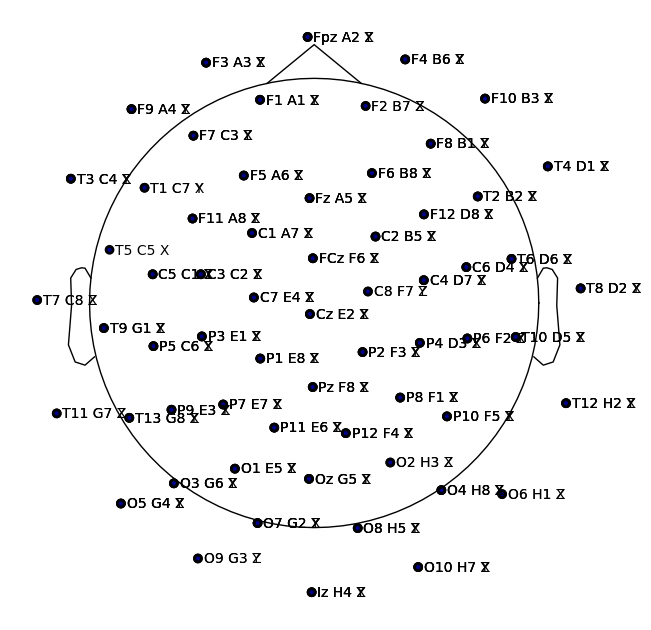

In [22]:
fig = raw_ica.plot_sensors(kind='topomap', show_names=True)

Here Frontal sensors start with letter 'F'

In [13]:
chs = ['F1 A1 Z','F1 A1 Y','F1 A1 X','F3 A3 Z','F3 A3 Y','F3 A3 X','F5 A6 Z','F5 A6 Y','F5 A6 X','F7 C3 Z','F7 C3 Y',
 'F7 C3 X','F9 A4 Z','F9 A4 Y','F9 A4 X','F11 A8 Z','F11 A8 Y','F11 A8 X','F2 B7 Z','F2 B7 X','F4 B6 Z','F4 B6 Y',
 'F4 B6 X','F6 B8 Z','F6 B8 Y','F6 B8 X','F8 B1 Z','F8 B1 Y','F8 B1 X','F10 B3 Z','F10 B3 Y','F10 B3 X','F12 D8 Z','F12 D8 Y','F12 D8 X',]
chan_idxs = [raw.ch_names.index(ch) for ch in chs]

#### Then plot the data before the ICA projections were applied. Use the arrow button to scroll through the trials.

In [15]:
%matplotlib inline
raw.plot(order=chan_idxs)

<mne_qt_browser._pg_figure.MNEQtBrowser(0x2544b5eb940) at 0x0000025445ED4F00>

The plot above shows the raw traces before the application of the ICA projections. Note the ocular artefacts in the OPM data at e.g. ~1 sec.

Then plot the same traces after the application of the ICA projections:

In [16]:
%matplotlib inline
raw_ica.plot(order=chan_idxs)

<mne_qt_browser._pg_figure.MNEQtBrowser(0x25452067290) at 0x000002545E40CE80>

Channels marked as bad:
none


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


As seen in the plot above, the ocular artefacts are clearly reduced.

## Preregistration and Publication

Example text:
"The data were down sampled to 250 Hz prior to Independent Component Analysis (ICA) and bandpass filtered at 1 – 40 Hz. Next the fastICA algorithm (`Hyvärinen and Oja, 2000`) was applied to the segmented data as implemented in MNE Python. Components containing cardiac artefacts and eyeblinks (identified in time course and topographies of the ICA components) were removed in each subject (3 – 5 over subjects) in the raw unfiltered data. "


## References

[Hyvärinen & Oja, 2002]: Hyvärinen, A., & Oja, E. (2002). Independent component analysis: algorithms and applications. *Neural Networks*, 13(4–5), 411–430. https://doi.org/10.1016/s0893-6080(00)00026-5


